In [41]:
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip && unzip v2_Annotations_Train_mscoco && \
wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip && unzip v2_Questions_Train_mscoco

--2024-04-12 11:48:07--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.161.104, 52.216.94.45, 54.231.202.64, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.161.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21708861 (21M) [application/zip]
Saving to: ‘v2_Annotations_Train_mscoco.zip.1’

v2_Annotations_Trai 100%[===================>]  20.70M  3.76MB/s    in 13s     

2024-04-12 11:48:22 (1.54 MB/s) - ‘v2_Annotations_Train_mscoco.zip.1’ saved [21708861/21708861]

Archive:  v2_Annotations_Train_mscoco.zip
replace v2_mscoco_train2014_annotations.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
--2024-04-12 11:49:34--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.32.0, 54.231.198.152, 52.216.54.232, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.32.0|:443... conne

In [42]:
!pip install transformers

In [43]:
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import json
import copy
import glob
import torch
import random
import operator
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from google.colab import files
from numpy.random import choice
from sklearn.manifold import TSNE
from collections import Counter, defaultdict
import pandas as pd
import csv
from torch.utils.data import Dataset
from torchvision.transforms import *
from tqdm.notebook import tqdm
import pickle
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models

In [44]:
annotations = json.load(open("v2_mscoco_train2014_annotations.json"))
questions = json.load(open("v2_OpenEnded_mscoco_train2014_questions.json"))

In [45]:
annotations.keys()

dict_keys(['info', 'license', 'data_subtype', 'annotations', 'data_type'])

In [46]:
annotations['annotations'][0]

{'question_type': 'what is this',
 'multiple_choice_answer': 'net',
 'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 458752,
 'answer_type': 'other',
 'question_id': 458752000}

In [47]:
questions.keys()

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])

In [48]:
questions['questions']

[{'image_id': 458752,
  'question': 'What is this photo taken looking through?',
  'question_id': 458752000},
 {'image_id': 458752,
  'question': 'What position is this man playing?',
  'question_id': 458752001},
 {'image_id': 458752,
  'question': 'What color is the players shirt?',
  'question_id': 458752002},
 {'image_id': 458752,
  'question': 'Is this man a professional baseball player?',
  'question_id': 458752003},
 {'image_id': 262146,
  'question': 'What color is the snow?',
  'question_id': 262146000},
 {'image_id': 262146,
  'question': 'What is the person doing?',
  'question_id': 262146001},
 {'image_id': 262146,
  'question': 'What color is the persons headwear?',
  'question_id': 262146002},
 {'image_id': 524291,
  'question': "What is in the person's hand?",
  'question_id': 524291000},
 {'image_id': 524291,
  'question': 'Is the dog waiting?',
  'question_id': 524291001},
 {'image_id': 524291,
  'question': 'Is the dog looking at a tennis ball or frisbee?',
  'question

In [49]:
questionid2question = {item['question_id']: item['question'] for item in questions['questions']}

In [50]:
questionid2question

{458752000: 'What is this photo taken looking through?',
 458752001: 'What position is this man playing?',
 458752002: 'What color is the players shirt?',
 458752003: 'Is this man a professional baseball player?',
 262146000: 'What color is the snow?',
 262146001: 'What is the person doing?',
 262146002: 'What color is the persons headwear?',
 524291000: "What is in the person's hand?",
 524291001: 'Is the dog waiting?',
 524291002: 'Is the dog looking at a tennis ball or frisbee?',
 393221000: 'Is the sky blue?',
 393221001: 'Is there snow on the mountains?',
 393221002: 'What is the white streak?',
 393223000: 'Is the window open?',
 393223001: 'What color is the toothbrush?',
 393223002: 'What is the child doing?',
 393223003: 'Is she brushing?',
 393224000: 'Is the man smiling?',
 393224001: 'What is the business man doing in the picture?',
 393224002: 'Does his tie pair well with his suit?',
 393224003: 'Does the man look happy?',
 393224004: 'Is this photo in color?',
 393224005:

In [51]:
annotations['annotations'][0]

{'question_type': 'what is this',
 'multiple_choice_answer': 'net',
 'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 458752,
 'answer_type': 'other',
 'question_id': 458752000}

In [52]:
def get_most_probable_answers(answers):
    answers_count = dict()
    for answer in answers:
        answers_count[answer['answer']] = answers_count.get(answer['answer'], 0) + 1
    max_answer = max(answers_count, key = answers_count.get)
    return max_answer

In [53]:
def build_dataset(questions, annotations):
    questionid2question = {item['question_id']: item['question'] for item in questions['questions']}
    questions = questions['questions'] # image_id, question, question_id
    annotations = annotations['annotations'] # image_id, question_id, answers
    question = [questionid2question[item['question_id']] for item in annotations]
    image_id = [item['image_id'] for item in annotations]
    answer = [get_most_probable_answers(item['answers']) for item in annotations]
    # df = data frame
    df = pd.DataFrame(list(zip(image_id, question, answer)), columns =['image_id', 'question', 'answer'])
    return df


In [54]:
df = build_dataset(questions, annotations)

In [55]:
df.head()

,image_id,question,answer
0,458752,What is this photo taken looking through?,net
1,458752,What position is this man playing?,pitcher
2,458752,What color is the players shirt?,orange
3,458752,Is this man a professional baseball player?,yes
4,262146,What color is the snow?,white


In [56]:
all_possible_answers = df['answer'].unique()
len(all_possible_answers)

22706

In [57]:
threshold_instance_per_class = 1000
threshold_num_classes = 20
sample_size = 1000

def choose_classes_strategy(filterd_answers_freq, threshold_num_classes=None, strategy=None):
    strategy = strategy.lower()
    assert strategy in ['max', 'min', 'random', None]

    if strategy is None:
        # choose all classes
        chosen_classes = filterd_answers_freq.keys()
    elif strategy == 'min':
        # choose classes which have minimum number of frequencies
        assert(threshold_num_classes is not None)
        chosen_classes = sorted(filterd_answers_freq, key=lambda x:filterd_answers_freq[x])[0:threshold_num_classes]
    elif strategy == 'max':
        # choose classes which have maximum number of frequencies
        assert(threshold_num_classes is not None)
        chosen_classes = sorted(filterd_answers_freq, key=lambda x:filterd_answers_freq[x], reverse=True)[0:threshold_num_classes]
    elif strategy == 'random':
        # choose classes randomly
        assert(threshold_num_classes is not None)
        chosen_classes = random.sample(list(filterd_answers_freq.keys()), threshold_num_classes)

    return chosen_classes


def filter_dataframe(df, chosen_classes, sample_size):
    sampled_rows = []
    # TODO 1: sampling from chosen classes

    # print(chosen_classes)
    for class_label in chosen_classes:
        # Filter rows based on class_label
        class_df = df[df['answer'] == class_label]
        # Randomly select a start index
        max_start_index = max(0, len(class_df) - sample_size)
        start_index = random.randint(0, max_start_index)
        # Choose items from the start index onward
        sampled_class_df = class_df.iloc[start_index:start_index+sample_size]
        sampled_rows.append(sampled_class_df)

    return pd.concat(sampled_rows)



def get_final_df(df, threshold_instance_per_class=None, threshold_num_classes=None, sample_size=None):
    ans_freq = df['answer'].value_counts()
    filterd_answers_freq = ans_freq[ans_freq > threshold_instance_per_class]
    chosen_classes = choose_classes_strategy(filterd_answers_freq, threshold_num_classes, strategy='random')
    filtered_df = filter_dataframe(df, chosen_classes, sample_size)
    return filtered_df



In [58]:
new_df = get_final_df(df, threshold_instance_per_class, threshold_num_classes, sample_size)

In [59]:
new_df

,image_id,question,answer
296208,216740,What color is the stop light in the foreground?,green
296213,216740,What color are the traffic lights?,green
296215,216740,What light is on the traffic light?,green
296216,216740,What color is the traffic light?,green
296258,478899,What color are his pants?,green
...,...,...,...
169592,572171,What color are the stoplights?,red
169671,441116,What color is the train?,red
169798,52693,What color is the buses?,red
169812,179017,What color shirt is the guy in the middle wear...,red


In [60]:
new_df.to_csv("new_df.csv")

In [61]:
new_df = pd.read_csv("new_df.csv", index_col = 0)

In [62]:
print(new_df)

        image_id                                           question answer
296208    216740    What color is the stop light in the foreground?  green
296213    216740                 What color are the traffic lights?  green
296215    216740                What light is on the traffic light?  green
296216    216740                   What color is the traffic light?  green
296258    478899                          What color are his pants?  green
...          ...                                                ...    ...
169592    572171                     What color are the stoplights?    red
169671    441116                           What color is the train?    red
169798     52693                           What color is the buses?    red
169812    179017  What color shirt is the guy in the middle wear...    red
169993    572279                            What color is the tail?    red

[20000 rows x 3 columns]



Number of Classes: 20

Which classes? (with count)
answer
green       1000
orange      1000
pink        1000
tennis      1000
3           1000
no          1000
0           1000
1           1000
yes         1000
bathroom    1000
frisbee     1000
black       1000
wood        1000
gray        1000
kitchen     1000
none        1000
left        1000
pizza       1000
5           1000
red         1000
Name: count, dtype: int64


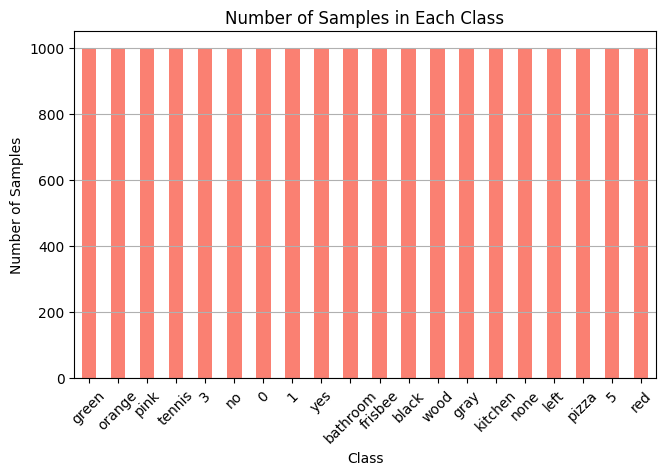

In [63]:
# TODO 2: make a report from dataset
# plot
# number of classes and which classes
num_classes = new_df['answer'].nunique()
print("\nNumber of Classes:", num_classes)

# which classes
class_distribution = new_df['answer'].value_counts()
print("\nWhich classes? (with count)")
print(class_distribution)

# Plotting
plt.figure(figsize=(7.5, 4.5))
class_distribution.plot(kind='bar', color='salmon')
plt.title('Number of Samples in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# # Exploratory Data Analysis (EDA)
# # Display basic statistics
# print("Basic Statistics:")
# print(new_df.describe())

# # Check data types and missing values
# print("\nData Types:")
# print(new_df.dtypes)
# print("\nMissing Values:")
# print(new_df.isnull().sum())


In [64]:
def train_val_test_split(df, train_portion = 0.9, val_portion = 0.05, test_portion = 0.05):
    df_train, df_val, df_test, _ = np.split(df.sample(frac=1, random_state=42), [int(train_portion * len(df)), int((train_portion + val_portion) * len(df)), int((train_portion + val_portion + test_portion) * len(df))])

    # TODO 3: Reset train, val , test dataframe index
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    return df_train, df_val, df_test


In [65]:
df_train, df_val, df_test = train_val_test_split(new_df)
max_question_len = max(new_df['question'].apply(lambda x: len(x)))
MAX_LEN = 100

In [66]:
len(new_df), len(df_train), len(df_val), len(df_test)

(20000, 18000, 1000, 1000)

In [67]:
max_question_len

99

In [68]:
def get_tokenizer_output(tokenizer, text, attr):
    return np.array(tokenizer(text, padding='max_length', max_length = MAX_LEN, truncation=True, return_tensors="pt")[attr])

In [69]:
train_transform = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
        ])

val_transform = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
        ])

test_transform = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
        ])

class SimpleVQADataset(Dataset):
    def __init__(self, df, tokenizer, classes, transform):
        super(SimpleVQADataset, self).__init__()
        self.df = df
        self.tokenizer = tokenizer
        self.labels = []
        self.label2idx = {c:i for i, c in enumerate(classes)}
        self.idx2label = {i:c for i, c in enumerate(classes)}
        self.mapping = self.cunstruct_mapping_dict()
        self.encodings = {}
        self.encodings['input_ids']=[]
        self.encodings['attention_mask']=[]
        self.transform = transform

        for index, row in df.iterrows():
            self.encodings['input_ids'].append(get_tokenizer_output(self.tokenizer, row['question'], 'input_ids'))
            self.encodings['attention_mask'].append(get_tokenizer_output(self.tokenizer, row['question'], 'attention_mask'))
            self.labels.append(self.label2idx[self.mapping[row['answer'].lower()]])
        self.encodings['input_ids'] = np.array(self.encodings['input_ids'])
        self.encodings['attention_mask'] = np.array(self.encodings['attention_mask'])

        self.img_ids = df['image_id']
        self.labels = np.array(self.labels).reshape(-1, 1)


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        image_id = self.img_ids[idx]
        item['image_id'] = image_id
        filename = 'COCO_train2014_'+ str(image_id).zfill(12) + '.jpg'
        trg = os.path.join('./images', filename)
        img = self.transform(Image.open(trg).convert('RGB'))
        item['image'] = img

        return item

    def cunstruct_mapping_dict(self, ):
        map_dict = {}
        for item in self.idx2label.values():
            map_dict[item.lower()] = item
        return map_dict



In [70]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [71]:
classes = new_df['answer'].unique()
classes

array(['green', 'orange', 'pink', 'tennis', '3', 'no', '0', '1', 'yes',
       'bathroom', 'frisbee', 'black', 'wood', 'gray', 'kitchen', 'none',
       'left', 'pizza', '5', 'red'], dtype=object)

In [72]:
train_dataset = SimpleVQADataset(df_train, tokenizer, classes, train_transform)
val_dataset = SimpleVQADataset(df_val, tokenizer, classes, val_transform)
test_dataset = SimpleVQADataset(df_test, tokenizer, classes, test_transform)

print("ٔNumber of samples in train split", len(train_dataset))
print("Number of samples in val split", len(val_dataset))
print("Number of samples in test split", len(test_dataset))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


ٔNumber of samples in train split 18000
Number of samples in val split 1000
Number of samples in test split 1000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [74]:
import os
import urllib.request
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import matplotlib.pyplot as plt

target_folder = './'
subfolder_name = 'images'
subfolder_path = os.path.join(target_folder, subfolder_name)

if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)

unique_image_ids = new_df['image_id'].unique()

def download_image(img_id):
    filename = 'COCO_train2014_'+ str(img_id).zfill(12) + '.jpg'
    src = os.path.join('https://vqa_mscoco_images.s3.amazonaws.com/train2014/', filename)
    trg = os.path.join(subfolder_path, filename)
    if not os.path.exists(trg):
        urllib.request.urlretrieve(src, trg)

# Using ThreadPoolExecutor to concurrently download images
with ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(download_image, unique_image_ids), total=len(unique_image_ids)))



100%|██████████| 14838/14838 [54:27<00:00,  4.54it/s]


In [75]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# VQA Model

In [76]:
# Step 3: Define the VQA model
class VQAModel(nn.Module):
    def __init__(self, image_feature_extractor, question_feature_extractor, hidden_dim, num_classes):
        super(VQAModel, self).__init__()
        # Image feature extractor (e.g., ResNet50)
        self.image_feature_extractor = image_feature_extractor

        # Question feature extractor (e.g., LSTM)
        self.question_feature_extractor = question_feature_extractor

        # Combined image and question classifier
        self.classifier = nn.Sequential(

            # Define the layers that combine image and question features
            # TODO 5: Linear(hidden_dim, hidden_dim), Dropout 0.2, ReLU, Linear

            nn.Linear(hidden_dim, hidden_dim),  # Linear layer to transform the concatenated features
            nn.Dropout(0.2),  # Dropout layer to prevent overfitting
            nn.ReLU(),  # ReLU activation function
            nn.Linear(hidden_dim, num_classes)  # Output layer for classification

        )

    def forward(self, image, input_ids, attention_mask):
        # Process the image through the image_features
        image_embedding = self.image_feature_extractor(image).squeeze((2, 3))

        # Process the question through the question_features
        question_embedding = self.question_feature_extractor(input_ids=input_ids,attention_mask=attention_mask).last_hidden_state.mean(dim=1)

        # Combine the image and question features
        # TODO 6: concatenate image embedding and question embedding

        combined_embedding = None
        combined_embedding = torch.cat((image_embedding, question_embedding), dim=1)


        # Make a prediction using the classifier
        output = self.classifier(combined_embedding)
        return output

In [ ]:
# Step 4: Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        for train_batch in tqdm(train_loader):
            images = train_batch['image'].squeeze(1).to(device)
            input_ids = train_batch['input_ids'].squeeze(1).to(device).to(device)
            attention_mask = train_batch['attention_mask'].squeeze(1).to(device)
            train_label = train_batch['labels'].squeeze(1).to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            # Compute the loss
            loss = criterion(outputs, train_label)

            # Backpropagation
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (preds == train_label).sum().item()
            total_samples += train_label.size(0)

            # Clear the gradients
            optimizer.zero_grad()

        # Print the loss for this epoch
        print(f"Train, Epoch {epoch + 1} : Loss = {total_loss / len(train_dataloader):.4f}, Accuracy = {total_correct / total_samples:.4f}")

# Step 5: Evaluate the model
def evaluate_model(model, val_loader, criterion, optimizer):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for val_batch in tqdm(val_loader):
            images = val_batch['image'].squeeze(1).to(device)
            input_ids = val_batch['input_ids'].squeeze(1).to(device).to(device)
            attention_mask = val_batch['attention_mask'].squeeze(1).to(device)
            val_label = val_batch['labels'].squeeze(1).to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)

            # Get the predicted answers
            _, preds = torch.max(outputs, dim=1)

            # Update total and correct predictions
            total_correct += (preds == val_label).sum().item()
            total_samples += val_label.size(0)

    print(f"Evaluation : Accuracy = {total_correct / total_samples:.4f}")

In [77]:
classes

array(['green', 'orange', 'pink', 'tennis', '3', 'no', '0', '1', 'yes',
       'bathroom', 'frisbee', 'black', 'wood', 'gray', 'kitchen', 'none',
       'left', 'pizza', '5', 'red'], dtype=object)

In [78]:
import torchvision

if __name__ == "__main__":
    # Set device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    hidden_dim = 512 + 768    # Replace with the desired hidden dimension

    # TODO 7: load resnet18 pretrained
    model_ft = torchvision.models.resnet18(pretrained=True)

    # TODO 8: use all layers except the last one which is for classification
    image_feature_extractor = nn.Sequential(*list(model_ft.children())[:-1])

    question_feature_extractor = DistilBertModel.from_pretrained('distilbert-base-uncased')
    num_classes = len(classes)

    model = VQAModel(image_feature_extractor, question_feature_extractor, hidden_dim, num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        for train_batch in tqdm(train_dataloader):
            images = train_batch['image'].squeeze(1).to(device)
            input_ids = train_batch['input_ids'].squeeze(1).to(device).to(device)
            attention_mask = train_batch['attention_mask'].squeeze(1).to(device)
            train_label = train_batch['labels'].squeeze(1).to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            # Compute the loss
            loss = criterion(outputs, train_label)

            # Backpropagation
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (preds == train_label).sum().item()
            total_samples += train_label.size(0)

            # Clear the gradients
            optimizer.zero_grad()
        print(f"Train, Epoch {epoch + 1} : Loss = {total_loss / len(train_dataloader):.4f}, Accuracy = {total_correct / total_samples:.4f}")


        model.eval()
        correct = 0
        total = 0
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        # with torch.no_grad():
        for val_batch in tqdm(val_dataloader):
            images = val_batch['image'].squeeze(1).to(device)
            input_ids = val_batch['input_ids'].squeeze(1).to(device).to(device)
            attention_mask = val_batch['attention_mask'].squeeze(1).to(device)
            val_label = val_batch['labels'].squeeze(1).to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)

            # Get the predicted answers
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, val_label)

            # Update total and correct predictions
            total_loss += loss.item()
            total_correct += (preds == val_label).sum().item()
            total_samples += val_label.size(0)

        print(f"Evaluation, Epoch {epoch + 1} : Loss = {total_loss / len(val_dataloader):.4f}, Accuracy = {total_correct / total_samples:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/282 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 282/282 [03:24<00:00,  1.99it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: Run

Train, Epoch 1 : Loss = 2.6235, Accuracy = 0.2291


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Evaluation, Epoch 1 : Loss = 2.6234, Accuracy = 0.2440


100%|██████████| 282/282 [03:13<00:00,  1.46it/s]


Train, Epoch 2 : Loss = 2.4257, Accuracy = 0.2948


100%|██████████| 16/16 [00:11<00:00,  1.44it/s]


Evaluation, Epoch 2 : Loss = 2.5153, Accuracy = 0.2730


100%|██████████| 282/282 [03:10<00:00,  1.48it/s]


Train, Epoch 3 : Loss = 2.3005, Accuracy = 0.3283


100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


Evaluation, Epoch 3 : Loss = 2.5807, Accuracy = 0.2670


100%|██████████| 282/282 [03:11<00:00,  1.48it/s]


Train, Epoch 4 : Loss = 2.1527, Accuracy = 0.3715


100%|██████████| 16/16 [00:11<00:00,  1.44it/s]


Evaluation, Epoch 4 : Loss = 2.4180, Accuracy = 0.3140


100%|██████████| 282/282 [03:09<00:00,  1.49it/s]


Train, Epoch 5 : Loss = 1.9814, Accuracy = 0.4194


100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


Evaluation, Epoch 5 : Loss = 2.4266, Accuracy = 0.3120


100%|██████████| 282/282 [03:10<00:00,  1.48it/s]


Train, Epoch 6 : Loss = 1.7894, Accuracy = 0.4743


100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


Evaluation, Epoch 6 : Loss = 2.5959, Accuracy = 0.3050


100%|██████████| 282/282 [03:10<00:00,  1.48it/s]


Train, Epoch 7 : Loss = 1.5742, Accuracy = 0.5361


100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


Evaluation, Epoch 7 : Loss = 2.7611, Accuracy = 0.3010


100%|██████████| 282/282 [03:10<00:00,  1.48it/s]


Train, Epoch 8 : Loss = 1.3390, Accuracy = 0.6041


100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


Evaluation, Epoch 8 : Loss = 2.6424, Accuracy = 0.3550


100%|██████████| 282/282 [03:08<00:00,  1.49it/s]


Train, Epoch 9 : Loss = 1.1196, Accuracy = 0.6761


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


Evaluation, Epoch 9 : Loss = 2.8237, Accuracy = 0.3540


100%|██████████| 282/282 [03:09<00:00,  1.49it/s]


Train, Epoch 10 : Loss = 0.9060, Accuracy = 0.7417


100%|██████████| 16/16 [00:07<00:00,  2.24it/s]

Evaluation, Epoch 10 : Loss = 3.1232, Accuracy = 0.3600


In [79]:
evaluate_model(model, test_dataloader, criterion, optimizer)

100%|██████████| 1000/1000 [00:16<00:00, 59.01it/s]

Evaluation : Accuracy = 0.3460
